In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2526'
MIN_MINUTES = 400

GETAFE_COLORS = {
    'primary': '#005999',    # Per100touches (correcto)
    'secondary': '#FF6B6B'   # Per90 (incorrecto) - Rojo para destacar error
}

PLAYER_CONFIG = {
    'name': 'Luis Milla',
    'search': 'Luis Milla',
    'team': 'Getafe'
}

SAVE_PATH_BASE = "./luis_milla_comparison/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# POOL COMPLETO DE MÉTRICAS RELEVANTES PARA MEDIOCENTRO
MC_RELEVANT_METRICS = [
    # PROGRESIÓN
    'Carries_PrgC', 'Carries_PrgDist', 'Progression_PrgP', 'Progression_PrgR', 'Receiving_PrgR',
    
    # CREATIVIDAD/CREACIÓN
    'expected_assists', 'key_passes', 'SCA_SCA90', 'GCA_GCA90', 
    'Pass Types_TB', 'Pass Types_Sw', 'assists', 'A-xAG',
    
    # PASES/CONTROL
    'pass_completion_pct', 'Outcomes_Cmp', 'Pass Types_Live', 'Pass Types_Dead',
    'Pass Types_CK', 'Pass Types_FK',
    
    # DEFENSIVO
    'Tkl+Int', 'Tackles_Tkl', 'interceptions', 'Recov', 
    'Challenges_Tkl%', 'Challenges_Tkl', 'Blocks_Pass', 'clearances',
    
    # CONDUCCIÓN/DRIBBLING
    'Carries_Carries', 'Carries_TotDist', 'Take-Ons_Succ', 'Take-Ons_Att',
    'Take-Ons_Succ%', 'Carries_Dis', 'Carries_Mis',
    
    # POSESIÓN/TOQUES
    'Touches_Touches', 'Touches_Att 3rd', 'Touches_Mid 3rd', 'Touches_Def 3rd',
    'Carries_1/3', 'Carries_CPA', 'Touches_Att Pen',
    
    # OTRAS
    'Fld', 'Fls', 'Aerial Duels_Won', 'Aerial Duels_Won%'
]

print(f"Total métricas relevantes MC: {len(MC_RELEVANT_METRICS)}")

Total métricas relevantes MC: 45


In [4]:
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2026-01-12 10:39:36,743 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-12 10:39:37,294 - database.connection - INFO - Database connection successful


Extraídos: 2317 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2526,DF,ENG,None,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '0',...",{}
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2526,FW,ENG,None,"{'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '23...",{}
2,278433de9fa4c551,Christian Nørgaard,Arsenal,ENG-Premier League,2526,MF,DEN,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...",{}
3,e94c51c954d24b45,Cristhian Mosquera,Arsenal,ENG-Premier League,2526,DF,ESP,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '1',...",{}
4,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2526,GK,ESP,None,"{'CS': '7', 'FK': '0', 'OG': '0', '/90': '-0.1...",{}


In [5]:
# Filtrar por minutos + posición MF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('MF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + MF: {df_filtered.shape[0]} jugadores")

Filtro 400+ min + MF: 609 jugadores


In [6]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [7]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 0 métricas


In [8]:
# Métricas que NO se normalizan
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

print("CALCULANDO AMBAS NORMALIZACIONES...")
print("=" * 70)

# 1. PER 100 TOUCHES (CORRECTO)
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"✓ Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# 2. PER 90 MINUTES (INCORRECTO para análisis posicional)
matches_90 = fbref_nums['minutes_played'] / 90

fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per90 = (fbref_per90.div(matches_90, axis=0)).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per90 = (understat_per90.div(matches_90, axis=0)).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"✓ Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# Combinar todas las métricas base + normalizadas
all_metrics_combined = pd.concat([
    fbref_nums, understat_nums,
    fbref_per100, understat_per100,
    fbref_per90, understat_per90
], axis=1)

print(f"\nTotal métricas combinadas: {all_metrics_combined.shape[1]}")

CALCULANDO AMBAS NORMALIZACIONES...
✓ Per100touches: 153 + 0
✓ Per90: 153 + 0

Total métricas combinadas: 491


In [9]:
# Buscar Luis Milla
search_pattern = PLAYER_CONFIG['search']

search_results = df_filtered[
    df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
]

print(f"LUIS MILLA SEARCH - '{search_pattern}':")
print("=" * 60)

if len(search_results) > 0:
    for _, p in search_results.iterrows():
        minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
        print(f"{p['unique_player_id']} - {p['player_name']}")
        print(f"  Team: {p['team']} | League: {p['league']}")
        print(f"  Position: {p['position']} | Minutes: {minutes}")
        print()
    
    milla_id = search_results.iloc[0]['unique_player_id']
    milla_name = search_results.iloc[0]['player_name']
    milla_team = search_results.iloc[0]['team']
    milla_idx = search_results.index[0]
    
    print(f"✓ ASSIGNED: {milla_name} ({milla_team}) -> {milla_id}")
    print(f"  Index: {milla_idx}")
else:
    print("✗ LUIS MILLA NOT FOUND")
    milla_id = None
    milla_idx = None

LUIS MILLA SEARCH - 'Luis Milla':
1f11fdfc005f39c4 - Luis Milla
  Team: Getafe | League: ESP-La Liga
  Position: MF | Minutes: 1484.0

✓ ASSIGNED: Luis Milla (Getafe) -> 1f11fdfc005f39c4
  Index: 670


In [10]:
# SELECCIONAR MÉTRICAS MANUALMENTE - Mejores de Luis Milla (MC Getafe)
print("SELECCIONANDO TOP 10 MÉTRICAS (mejores de Milla, relevantes MC)...")
print("=" * 70)

# TOP 10 MÉTRICAS DONDE MILLA ES BUENO (P70+) Y SON RELEVANTES PARA MC
# Agrupadas por categoría para orden visual
top10_metrics_base = [
    # PROGRESIÓN
    'Progression_PrgP',      # P80.7 - Pases progresivos
    
    # CREATIVIDAD / ASISTENCIAS
    'key_passes',            # P88.1 - Pases clave
    'expected_assists',      # P77.1 - Asistencias esperadas
    'assists',               # P97.1 - Asistencias
    'A-xAG',                 # P98.2 - Assists overperformance
    
    # BALÓN PARADO / DISTRIBUCIÓN
    'Pass Types_Dead',       # P96.7 - Pases de balón parado
    'Pass Types_Sw',         # P93.0 - Cambios de juego
    
    # DEFENSIVAS
    'Recov',                 # P89.0 - Recuperaciones
    'interceptions',         # P65.0 - Intercepciones
    
    # POSESIÓN
    'Touches_Mid 3rd',       # P72.6 - Toques mediocampo
]

print(f"TOP 10 MÉTRICAS SELECCIONADAS (mejores de Milla, relevantes MC):")
print(f"{'='*70}")

# Calcular percentiles para verificación
mc_per100_cols = [f"{m}_per100touches" for m in top10_metrics_base if f"{m}_per100touches" in fbref_per100.columns]
mc_per90_cols = [f"{m}_per90" for m in top10_metrics_base if f"{m}_per90" in fbref_per90.columns]

per100_pct = fbref_per100[mc_per100_cols].rank(pct=True) * 98 + 1
per90_pct = fbref_per90[mc_per90_cols].rank(pct=True) * 98 + 1

milla_per100_pct = per100_pct.loc[milla_idx]
milla_per90_pct = per90_pct.loc[milla_idx]

# Mostrar comparación
for i, metric in enumerate(top10_metrics_base, 1):
    per100_col = f"{metric}_per100touches"
    per90_col = f"{metric}_per90"
    
    if per100_col in milla_per100_pct.index and per90_col in milla_per90_pct.index:
        pct100 = milla_per100_pct[per100_col]
        pct90 = milla_per90_pct[per90_col]
        diff = abs(pct100 - pct90)
        print(f"{i:2d}. {metric:30s} | Per100: {pct100:5.1f} | Per90: {pct90:5.1f} | Diff: {diff:5.1f}")
    else:
        print(f"{i:2d}. {metric:30s} | (metric not available)")

print(f"\n✓ Métricas seleccionadas manualmente basadas en:")
print(f"  - Relevancia para MEDIOCENTRO")
print(f"  - Fortalezas de Luis Milla (P70+)")
print(f"  - Estilo Getafe (recuperaciones, balón parado, distribución)")

SELECCIONANDO TOP 10 MÉTRICAS (mejores de Milla, relevantes MC)...
TOP 10 MÉTRICAS SELECCIONADAS (mejores de Milla, relevantes MC):
 1. Progression_PrgP               | Per100:  80.7 | Per90:  66.8 | Diff:  13.8
 2. key_passes                     | Per100:  88.1 | Per90:  81.3 | Diff:   6.8
 3. expected_assists               | Per100:  77.1 | Per90:  73.8 | Diff:   3.3
 4. assists                        | Per100:  97.1 | Per90:  97.1 | Diff:   0.0
 5. A-xAG                          | Per100:  98.2 | Per90:  97.4 | Diff:   0.8
 6. Pass Types_Dead                | Per100:  96.7 | Per90:  93.4 | Diff:   3.4
 7. Pass Types_Sw                  | Per100:  93.0 | Per90:  89.8 | Diff:   3.1
 8. Recov                          | Per100:  89.0 | Per90:  79.2 | Diff:   9.8
 9. interceptions                  | Per100:  65.0 | Per90:  59.4 | Diff:   5.6
10. Touches_Mid 3rd                | Per100:  72.6 | Per90:  56.5 | Diff:  16.1

✓ Métricas seleccionadas manualmente basadas en:
  - Relevancia par

In [11]:
# Preparar DataFrames para el radar
print("PREPARANDO DATAFRAMES PARA RADAR...")
print("=" * 70)

# Base columns + minutes/matches (necesarios para el plot)
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
minutes_cols = ['minutes_played', 'matches_played']

# 1. DataFrame PER100TOUCHES
top10_per100_cols = [f"{m}_per100touches" for m in top10_metrics_base]

# Calcular percentiles para métricas seleccionadas
selected_per100 = fbref_per100[top10_per100_cols]
selected_per100_pct = (selected_per100.rank(pct=True) * 98 + 1).round(0).astype('Int64')
selected_per100_pct.columns = [f"{col}_pct" for col in selected_per100.columns]

df_per100 = pd.concat([
    df_filtered[base_cols].reset_index(drop=True),
    fbref_nums[minutes_cols].reset_index(drop=True),  # Añadir minutes/matches
    selected_per100.reset_index(drop=True),
    selected_per100_pct.reset_index(drop=True)
], axis=1)

print(f"✓ DataFrame Per100touches: {df_per100.shape}")
print(f"  Incluye: {', '.join(minutes_cols)}")

# 2. DataFrame PER90 (renombrar columnas para coincidir)
top10_per90_cols = [f"{m}_per90" for m in top10_metrics_base if f"{m}_per90" in fbref_per90.columns]

selected_per90 = fbref_per90[top10_per90_cols]
selected_per90_pct = (selected_per90.rank(pct=True) * 98 + 1).round(0).astype('Int64')
selected_per90_pct.columns = [f"{col}_pct" for col in selected_per90.columns]

# RENOMBRAR per90 → per100touches (solo nombres, NO valores)
rename_map = {col: col.replace('_per90', '_per100touches') for col in selected_per90.columns}
rename_map_pct = {col: col.replace('_per90', '_per100touches') for col in selected_per90_pct.columns}

selected_per90_renamed = selected_per90.rename(columns=rename_map)
selected_per90_pct_renamed = selected_per90_pct.rename(columns=rename_map_pct)

df_per90 = pd.concat([
    df_filtered[base_cols].reset_index(drop=True),
    fbref_nums[minutes_cols].reset_index(drop=True),  # Añadir minutes/matches
    selected_per90_renamed.reset_index(drop=True),
    selected_per90_pct_renamed.reset_index(drop=True)
], axis=1)

# CAMBIAR ID de Milla en df_per90
milla_mask = df_per90['unique_player_id'] == milla_id
df_per90.loc[milla_mask, 'unique_player_id'] = f"{milla_id}_per90"

print(f"✓ DataFrame Per90 (renamed): {df_per90.shape}")
print(f"  Milla ID changed to: {df_per90.loc[milla_mask, 'unique_player_id'].iloc[0]}")

# 3. CONCATENAR ambos DataFrames
df_combined = pd.concat([df_per100, df_per90], ignore_index=True)

# Limpieza
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_combined = clean_series_values(df_combined)

print(f"✓ DataFrame Combined: {df_combined.shape}")
print(f"\nColumnas incluidas:")
print(f"  Base: {', '.join(base_cols)}")
print(f"  Context: {', '.join(minutes_cols)}")
print(f"  Métricas: {len(top10_per100_cols)} métricas + percentiles")

print(f"\nVerificación IDs de Milla:")
milla_rows = df_combined[df_combined['player_name'].str.contains('Milla', case=False, na=False)]
print(milla_rows[['unique_player_id', 'player_name', 'team']].to_string(index=False))

PREPARANDO DATAFRAMES PARA RADAR...
✓ DataFrame Per100touches: (609, 28)
  Incluye: minutes_played, matches_played
✓ DataFrame Per90 (renamed): (609, 28)
  Milla ID changed to: 1f11fdfc005f39c4_per90
✓ DataFrame Combined: (1218, 28)

Columnas incluidas:
  Base: unique_player_id, player_name, team, league, season, position
  Context: minutes_played, matches_played
  Métricas: 10 métricas + percentiles

Verificación IDs de Milla:
      unique_player_id player_name     team
      d5596455a03bc3df  Pere Milla Espanyol
      1f11fdfc005f39c4  Luis Milla   Getafe
      d5596455a03bc3df  Pere Milla Espanyol
1f11fdfc005f39c4_per90  Luis Milla   Getafe


In [12]:
# Configurar métricas para el radar (usando nombres per100touches)
radar_metrics = [f"{m}_per100touches" for m in top10_metrics_base]

# Títulos claros y representativos (mismo orden que top10_metrics_base)
metric_titles_map = {
    # PROGRESIÓN
    'Progression_PrgP': 'Pases Progresivos',
    
    # CREATIVIDAD / ASISTENCIAS
    'key_passes': 'Pases Clave',
    'expected_assists': 'xAsistencias',
    'assists': 'Asistencias',
    'A-xAG': 'Assists - xAG',
    
    # BALÓN PARADO / DISTRIBUCIÓN
    'Pass Types_Dead': 'Pases Balón Parado',
    'Pass Types_Sw': 'Cambios de Juego',
    
    # DEFENSIVAS
    'Recov': 'Recuperaciones',
    'interceptions': 'Intercepciones',
    
    # POSESIÓN
    'Touches_Mid 3rd': 'Toques Mediocampo'
}

radar_titles = [metric_titles_map[m] for m in top10_metrics_base]

print("MÉTRICAS PARA RADAR (agrupadas por categoría):")
print("=" * 70)
for i, (metric, title) in enumerate(zip(radar_metrics, radar_titles), 1):
    print(f"{i:2d}. {metric:40s} → {title}")

print(f"\nTotal: {len(radar_metrics)} métricas")

MÉTRICAS PARA RADAR (agrupadas por categoría):
 1. Progression_PrgP_per100touches           → Pases Progresivos
 2. key_passes_per100touches                 → Pases Clave
 3. expected_assists_per100touches           → xAsistencias
 4. assists_per100touches                    → Asistencias
 5. A-xAG_per100touches                      → Assists - xAG
 6. Pass Types_Dead_per100touches            → Pases Balón Parado
 7. Pass Types_Sw_per100touches              → Cambios de Juego
 8. Recov_per100touches                      → Recuperaciones
 9. interceptions_per100touches              → Intercepciones
10. Touches_Mid 3rd_per100touches            → Toques Mediocampo

Total: 10 métricas


GENERATING COMPARISON RADAR: PER100TOUCHES vs PER90
  Player 1 (Per100): 1f11fdfc005f39c4
  Player 2 (Per90): 1f11fdfc005f39c4_per90
  Dataset: 1218 rows (incluye ambas versiones de Milla)
  Colors: ['#005999', '#FF6B6B']
✓ Radar generado
✓ Tabla generada
✓ Combined: ./luis_milla_comparison/milla_per100_vs_per90_combined.png


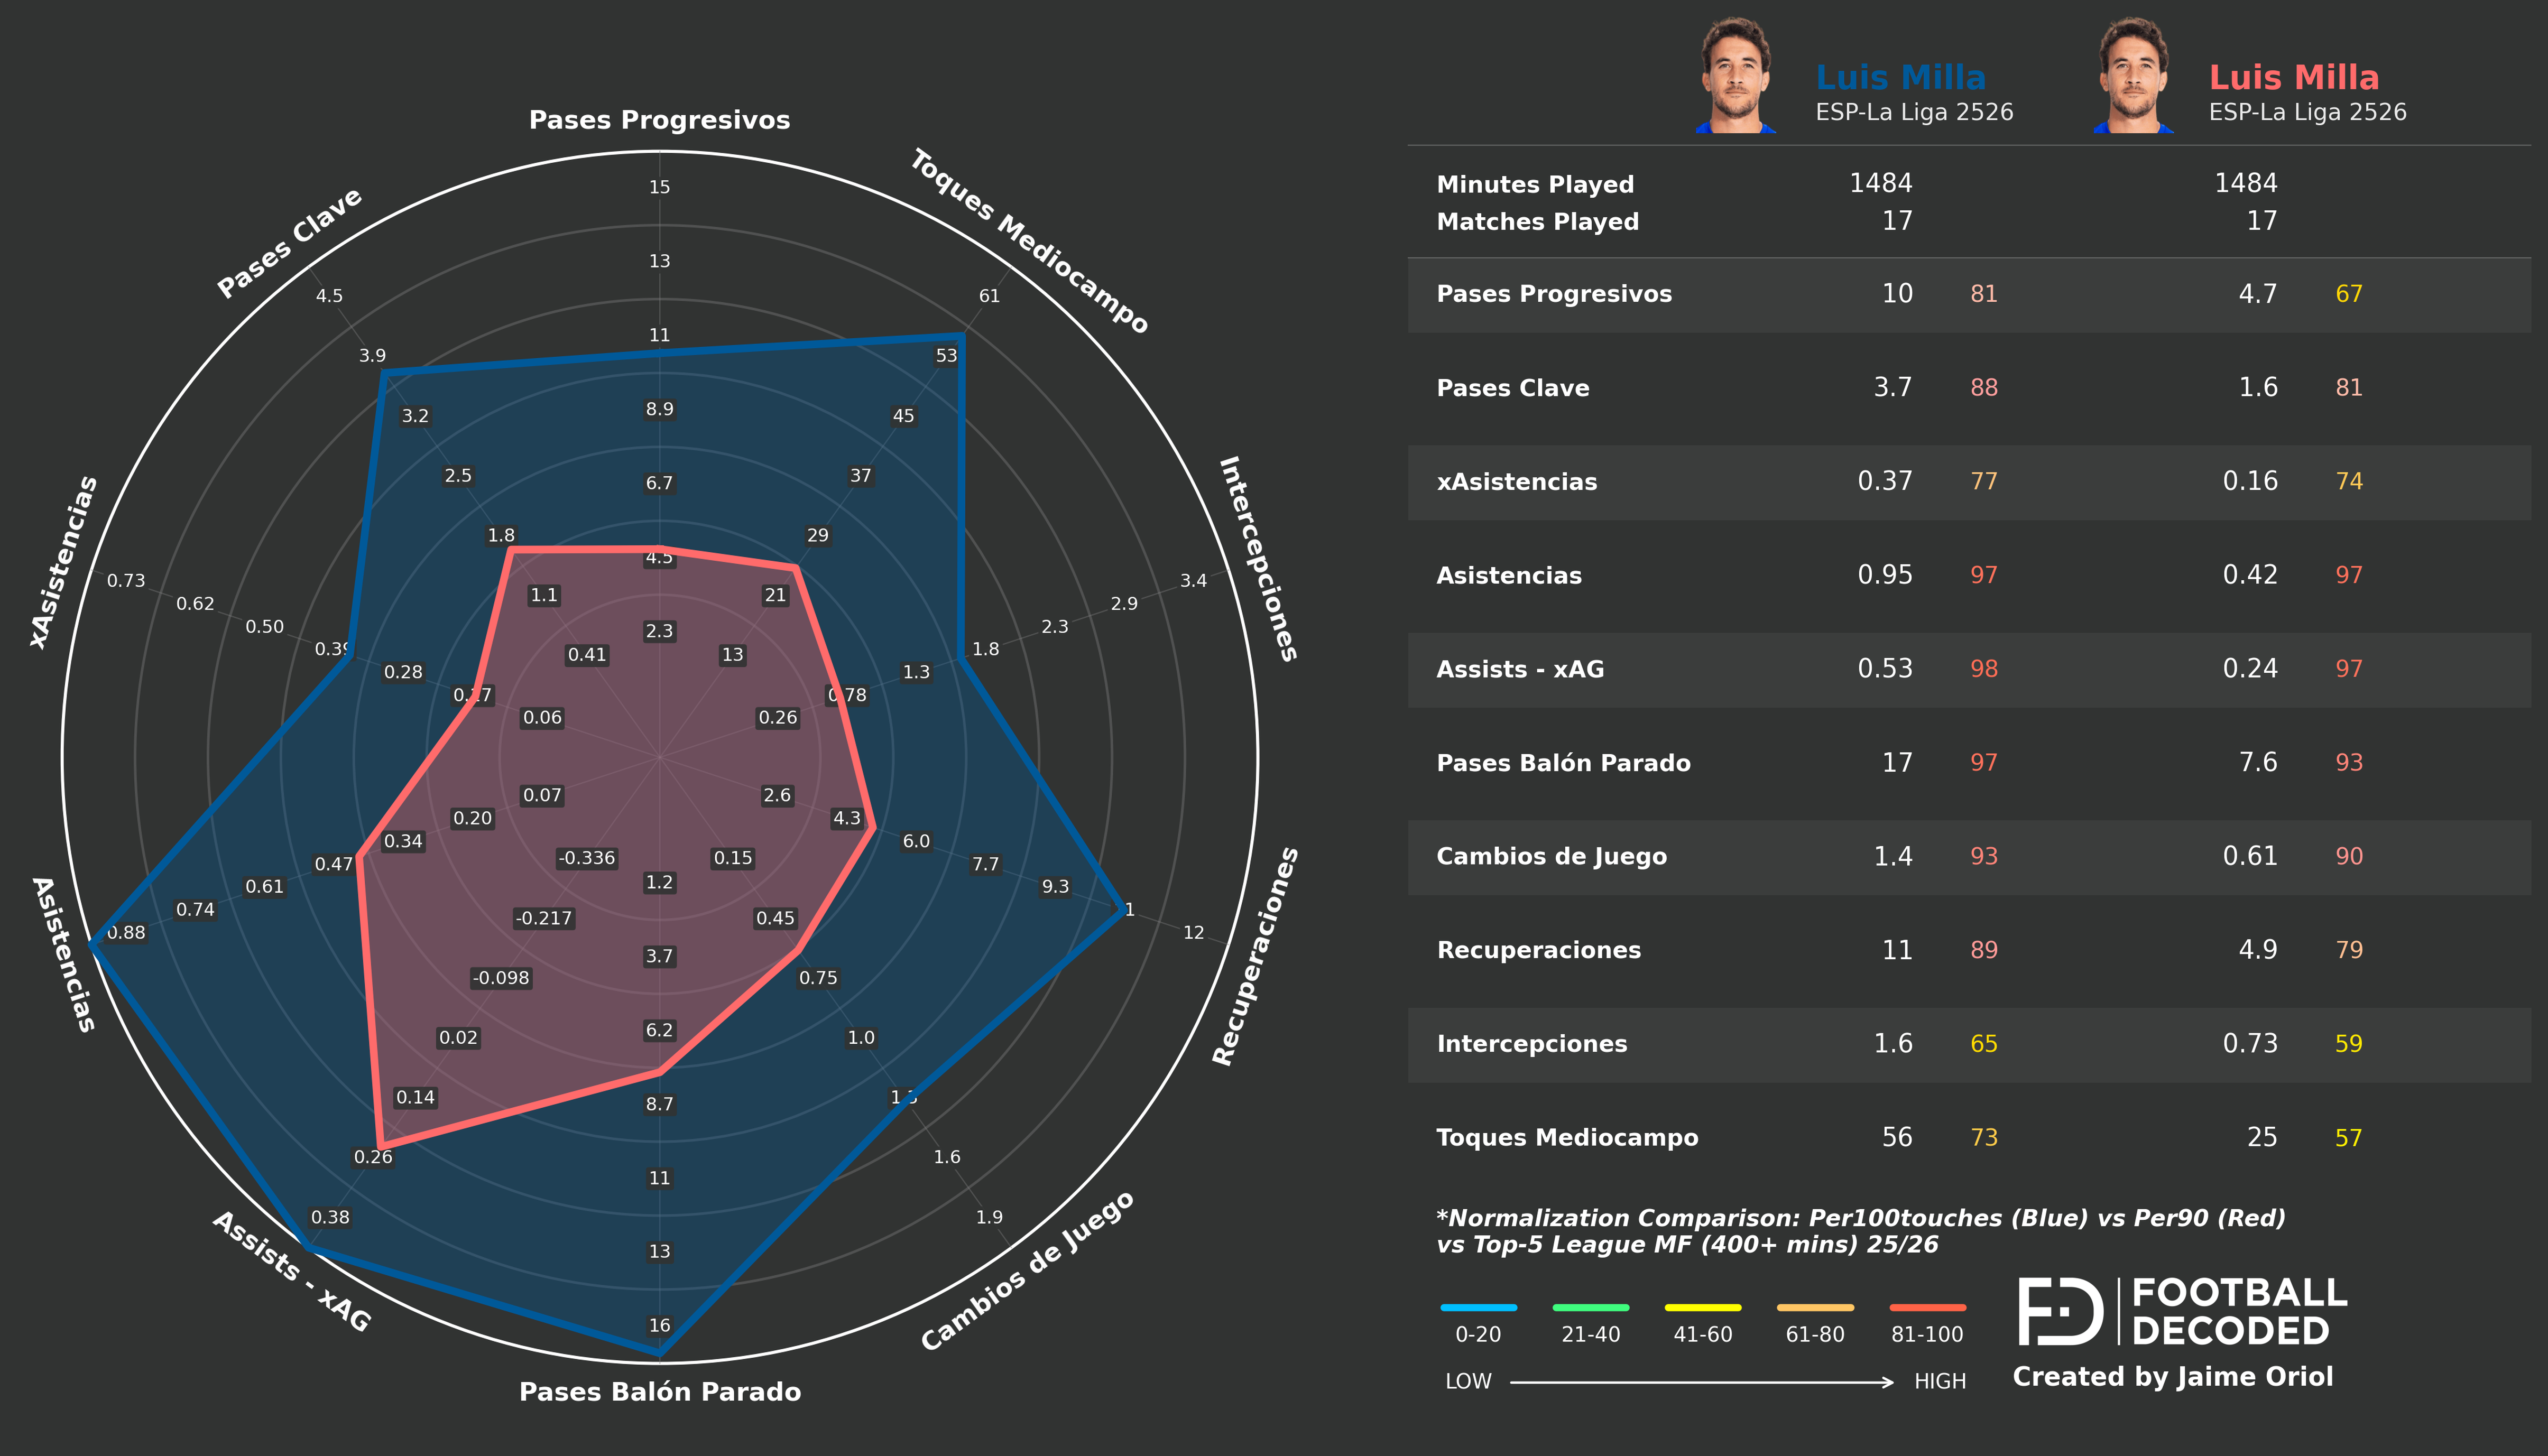


COMPARISON RADAR SUMMARY
✓ Comparison radar generated successfully
Player: Luis Milla (Getafe)
Comparison: Per100touches (CORRECTO) vs Per90 (INCORRECTO)
Métricas: TOP 10 con mayor diferencia de percentiles
Files saved in: ./luis_milla_comparison/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

if milla_id:
    print("GENERATING COMPARISON RADAR: PER100TOUCHES vs PER90")
    print("=" * 70)
    
    player1_id = milla_id  # Per100touches
    player2_id = f"{milla_id}_per90"  # Per90
    
    # Team logos
    team_logos = {
        milla_team: '/home/jaime/FD/data/blog/caras/milla.png',
        f"{milla_team}_per90": '/home/jaime/FD/data/blog/caras/milla.png'
    }
    
    print(f"  Player 1 (Per100): {player1_id}")
    print(f"  Player 2 (Per90): {player2_id}")
    print(f"  Dataset: {df_combined.shape[0]} rows (incluye ambas versiones de Milla)")
    print(f"  Colors: {[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']]}")
    
    try:
        # Radar comparativo
        create_player_radar(
            df_data=df_combined,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            team_colors=[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']],
            save_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_radar.png",
            use_swarm=False,
            show_plot=False
        )
        print("✓ Radar generado")
        
        # Tabla comparativa
        create_stats_table(
            df_data=df_combined,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=radar_metrics,
            metric_titles=radar_titles,
            team_colors=[GETAFE_COLORS['primary'], GETAFE_COLORS['secondary']],
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_table.png",
            footer_text=f"Normalization Comparison: Per100touches (Blue) vs Per90 (Red)\nvs Top-5 League MF ({MIN_MINUTES}+ mins) 25/26",
            show_plot=False
        )
        print("✓ Tabla generada")
        
        # Combinar
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_radar.png",
            table_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_table.png",
            output_path=f"{SAVE_PATH_BASE}milla_per100_vs_per90_combined.png"
        )
        print(f"✓ Combined: {SAVE_PATH_BASE}milla_per100_vs_per90_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}milla_per100_vs_per90_combined.png"))
        
        print("\n" + "=" * 70)
        print("COMPARISON RADAR SUMMARY")
        print("=" * 70)
        print(f"✓ Comparison radar generated successfully")
        print(f"Player: {milla_name} ({milla_team})")
        print(f"Comparison: Per100touches (CORRECTO) vs Per90 (INCORRECTO)")
        print(f"Métricas: TOP 10 con mayor diferencia de percentiles")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("✗ No se puede generar radar")